In [1]:
import numpy as np, healpy as hp, curvedsky as cs, cmb, tools_multitracer as mass, basic, cosmology, tqdm, local, plottools as pl
from scipy.integrate import quad
from matplotlib.pyplot import *
from scipy.interpolate import InterpolatedUnivariateSpline as spline

In [2]:
zmin, zmax = 1e-2, 100.
zn = 10000
H0 = 70.
Om = .3
Ov = .7
w0 = -1.
wa = 0.
zbn = 3
nu = 535.
fspec = {spec: local.data_directory()['mas'] + 'spec/cl'+spec+'.dat' for spec in ['kk','II','gg','kI','kg','Ig']}

In [3]:
cps = {'H0':H0,'Om':Om,'Ov':Ov,'w0':w0,'wa':wa}
zi  = np.linspace(zmin,zmax,zn)
Hzi = basic.cosmofuncs.hubble(zi,divc=True,**cps)
rzi = basic.cosmofuncs.dist_comoving(zi,**cps)
rzs = basic.cosmofuncs.dist_comoving([1100.],**cps)[0]
Dzi = basic.cosmofuncs.growth_factor(zi,normed=True,**cps)

In [4]:
zbin = basic.galaxy.zbin(zbn,2.,1.,1.)
dndzi = basic.galaxy.dndz_sf(zi,2.,1.,1.)
pz0 = basic.galaxy.photoz_error(zi,[zbin[0],zbin[1]],sigma=.03,zbias=0.)
pz1 = basic.galaxy.photoz_error(zi,[zbin[1],zbin[2]],sigma=.03,zbias=0.)
pz2 = basic.galaxy.photoz_error(zi,[zbin[2],zbin[3]],sigma=.03,zbias=0.)

In [5]:
w = {}
tracers = ['k','I','g0','g1','g2']

In [6]:
w['g0'] = cosmology.window_gal(Hzi,rzi,dndzi*pz0)
w['g1'] = cosmology.window_gal(Hzi,rzi,dndzi*pz1)
w['g2'] = cosmology.window_gal(Hzi,rzi,dndzi*pz2)

In [7]:
w['I'] = cosmology.window_cib(rzi,zi,nu)

0.01578809101673722


In [8]:
w['k'] = cosmology.window_kap(rzi,zi,rzs,Om,H0/3e5)

In [9]:
# compute linear matter P(k)
k, pk0 = cosmology.camb_pk(H0=H0,Om=Om,z=[0.],kmax=100.,minkh=1e-5,maxkh=50,npoints=1000)
Pk = spline(k,pk0)

In [10]:
N = 0
for I, m0 in enumerate(tracers):
    for J, m1 in enumerate(tracers):
        if J<I: continue
        N += 1
print(N)

15


In [11]:
lmin, lmax = 5, 2048
ln = 200
l  = np.linspace(lmin,lmax,ln)
ll = np.linspace(lmin,lmax,lmax-lmin+1)
cl = {}
for I, m0 in enumerate(tracers):
    for J, m1 in enumerate(tracers):
        if J<I: continue
        cl[m0+m1] = np.zeros(lmax-lmin+1)
        cli = np.zeros(ln)
        for i, L in tqdm.tqdm(enumerate(l),desc=m0+m1):
            integ = Dzi**2*Pk(L/rzi)/Hzi * w[m0]*w[m1] * (zi[1]-zi[0]) 
            cli[i] = np.sum(integ[:-1])
        cl[m0+m1] = spline(l,cli)(ll)

kk: 200it [00:00, 972.07it/s]
kI: 200it [00:00, 1105.78it/s]
kg0: 200it [00:00, 1144.73it/s]
kg1: 200it [00:00, 1113.49it/s]
kg2: 200it [00:00, 1125.01it/s]
II: 200it [00:00, 1016.98it/s]
Ig0: 200it [00:00, 1089.32it/s]
Ig1: 200it [00:00, 1217.40it/s]
Ig2: 200it [00:00, 1154.63it/s]
g0g0: 200it [00:00, 1204.14it/s]
g0g1: 200it [00:00, 1278.44it/s]
g0g2: 200it [00:00, 1271.55it/s]
g1g1: 200it [00:00, 1257.12it/s]
g1g2: 200it [00:00, 1261.10it/s]
g2g2: 200it [00:00, 1263.32it/s]


In [12]:
np.savetxt(fspec['kk'],np.array((ll,cl['kk'])))
np.savetxt(fspec['kI'],np.array((ll,cl['kI'])))
np.savetxt(fspec['II'],np.array((ll,cl['II'])))
np.savetxt(fspec['kg'],np.array((ll,cl['kg0'],cl['kg1'],cl['kg2'])))
np.savetxt(fspec['Ig'],np.array((ll,cl['Ig0'],cl['Ig1'],cl['Ig2'])))
np.savetxt(fspec['gg'],np.array((ll,cl['g0g0'],cl['g1g1'],cl['g2g2'])))

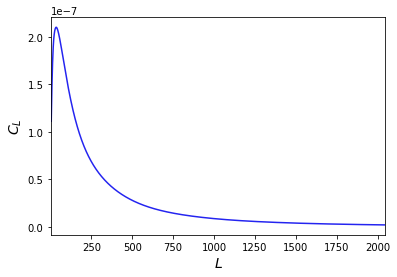

In [13]:
pl.plot_1dstyle(xmin=1,xmax=lmax)
plot(ll,cl['kk'])

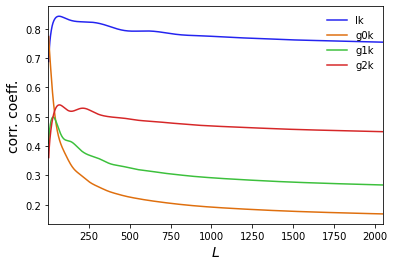

In [14]:
pl.plot_1dstyle(xmin=1,xmax=lmax,ylab='corr. coeff.')
plot(ll,cl['kI']/np.sqrt(cl['II']*cl['kk']),label='Ik')
plot(ll,cl['kg0']/np.sqrt(cl['g0g0']*cl['kk']),label='g0k')
plot(ll,cl['kg1']/np.sqrt(cl['g1g1']*cl['kk']),label='g1k')
plot(ll,cl['kg2']/np.sqrt(cl['g2g2']*cl['kk']),label='g2k')
legend()

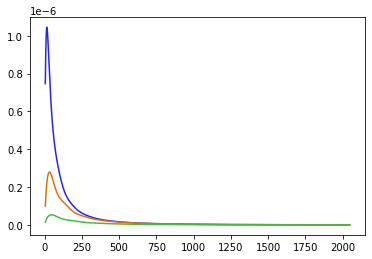

In [15]:
plot(ll,cl['g0g0'])
plot(ll,cl['g1g1'])
plot(ll,cl['g2g2'])

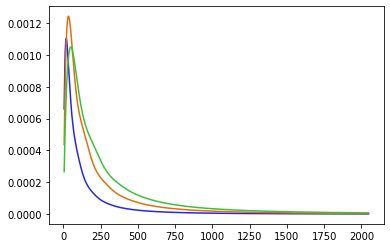

In [16]:
plot(ll,cl['Ig0'])
plot(ll,cl['Ig1'])
plot(ll,cl['Ig2'])

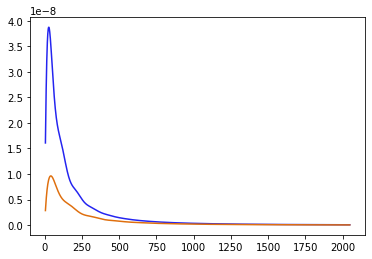

In [17]:
plot(ll,cl['g0g1'])
plot(ll,cl['g1g2'])